<a href="https://colab.research.google.com/github/siyuanchai1999/COVIDNet/blob/master/COVID_CAM(ResNet50)_REVISED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
!pip install gputil
!pip install psutil
!pip install humanize

# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=e214fe4a45a3ed858186dc4fb043963dbb0de8ceade34f1aeb978b0d2aa836ac
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(30),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_set = datasets.ImageFolder("/content/drive/My Drive/Colab Notebooks/data/Train",transform)
test_set   = datasets.ImageFolder("/content/drive/My Drive/Colab Notebooks/data/Test", test_transform)
val_set   = datasets.ImageFolder("/content/drive/My Drive/Colab Notebooks/data/Validation",transform)
clinical_test_set = datasets.ImageFolder("/content/drive/My Drive/Colab Notebooks/data/Clinical_test_data", test_transform)
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size= BATCH_SIZE,
                                       shuffle=True, num_workers = 4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE,  
                                       shuffle=True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE,  
                                       shuffle=True, num_workers = 4)
clinical_test_loader = torch.utils.data.DataLoader(clinical_test_set, batch_size = BATCH_SIZE,  
                                       shuffle=True, num_workers = 4)
classes = train_set.classes
device = torch.device("cuda")

# Define Modified ResNet50 Model

In [0]:
# ResNet Class
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # define the resnet50
        self.resnet = resnet50(pretrained=True)
                
        num_ftrs = self.resnet.fc.in_features
       
        self.resnet.fc = nn.Sequential(nn.Linear(num_ftrs, 2),
                                       #nn.Dropout(0.5))
                                                        )
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier = self.resnet.fc
        
        # gradient placeholder
        self.gradients = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradients = grad
    
    def get_activations(self, x):
        return self.features(x)
    
    def get_activations_gradient(self):
        return self.gradients
    
    def forward(self, x):
        # extract the features
        
        x = self.features(x) 
        # register the hook
        if x.requires_grad:
            h = x.register_hook(self.activations_hook)
        # complete the forward pass
        x = self.avgpool(x)
        
        x = x.view((x.shape[0], -1))
        
        x = self.classifier(x)
        return x


In [0]:
model = ResNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,512,130 total parameters.
23,512,130 training parameters.


# Train

In [0]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
num_epochs = 3

for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_val_loss = 0.0
    train_correct = 0
    val_correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, outputs = torch.max(outputs, 1)
        train_correct += (outputs == labels).float().sum()
        running_train_loss += loss.item()
    train_acc = (train_correct / len(train_set)).item()
    train_loss_history.append(running_train_loss)
    train_acc_history.append(train_acc)
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device) 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, outputs = torch.max(outputs, 1)
            val_correct += (outputs == labels).float().sum()
            
    val_acc = (val_correct / len(val_set)).item()
    val_loss_history.append(running_val_loss)
    val_acc_history.append(val_acc)
    print('epoch: ', epoch+1,", train_loss:", running_train_loss, "train_acc:,", train_acc,  ", val_loss:", running_val_loss, ", val_acc:", val_acc)
    mem_report()
print('Finished Training')

epoch:  1 , train_loss: 7.311757594347 train_acc:, 0.8412060141563416 , val_loss: 2.9792295694351196 , val_acc: 0.8939393758773804
CPU RAM Free: 24.8 GB
GPU 0 ... Mem Free: 2801MB / 16280MB | Utilization  83%
epoch:  2 , train_loss: 2.1202374286949635 train_acc:, 0.9467336535453796 , val_loss: 3.1911152601242065 , val_acc: 0.8924242258071899
CPU RAM Free: 24.8 GB
GPU 0 ... Mem Free: 2801MB / 16280MB | Utilization  83%
epoch:  3 , train_loss: 1.2631809934973717 train_acc:, 0.9718592762947083 , val_loss: 1.3772345036268234 , val_acc: 0.924242377281189
CPU RAM Free: 24.8 GB
GPU 0 ... Mem Free: 2801MB / 16280MB | Utilization  83%
Finished Training


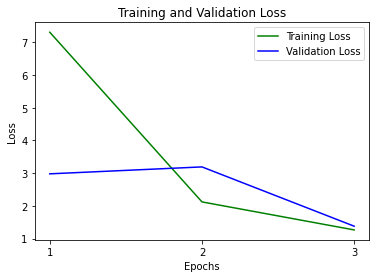

In [0]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_loss_history, 'g', label='Training Loss')
plt.plot(epochs, val_loss_history, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(1,num_epochs+1), range(1,num_epochs+1))
plt.show()

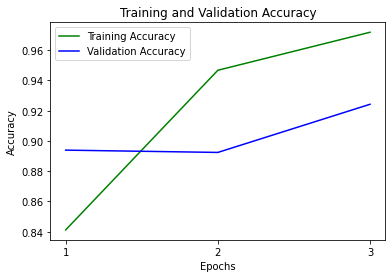

In [0]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_acc_history, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(1,num_epochs+1), range(1,num_epochs+1))
plt.show()

# Save Model and Evaluate

In [0]:
#torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/best_model_clinical(1).pt')
#model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/best_model_clinical(1).pt'))

In [0]:
model.eval()
model.to('cuda')
from sklearn.metrics import classification_report, confusion_matrix
#Confusion Matrix and Classification Report
Y_true = []
Y_pred = []
Y_score = []
tp = []
tp_scores = []
fp = []
fp_scores = []
tn = []
tn_scores = []
fn = []
fn_scores = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = torch.softmax(model(inputs), dim = 1)
      _, predicted = torch.max(outputs, 1)
      score = outputs[:,1]
            
      for j in range(len(inputs)):
          Y_true.append(labels.cpu().numpy()[j])
          Y_pred.append(predicted.cpu().numpy()[j]) 
          Y_score.append(score.cpu().numpy()[j]) 
          if (Y_pred[BATCH_SIZE*i+j] == 1 and Y_true[BATCH_SIZE*i+j] == 1):
              tp.append(inputs[j])
              tp_scores.append(score[j])
          elif (Y_pred[BATCH_SIZE*i+j] == 1 and Y_true[BATCH_SIZE*i+j] == 0):
              fp.append(inputs[j])
              fp_scores.append(score[j])
          elif (Y_pred[BATCH_SIZE*i+j] == 0 and Y_true[BATCH_SIZE*i+j] == 0):
              tn.append(inputs[j])
              tn_scores.append(score[j])
          elif (Y_pred[BATCH_SIZE*i+j] == 0 and Y_true[BATCH_SIZE*i+j] == 1):
              fn.append(inputs[j])
              fn_scores.append(score[j])

print(confusion_matrix(Y_true, Y_pred))
target_names = ['COVID-Neg', 'COVID-Pos']
print(classification_report(Y_true, Y_pred, target_names=target_names))

[[584   2]
 [ 33  41]]
              precision    recall  f1-score   support

   COVID-Neg       0.95      1.00      0.97       586
   COVID-Pos       0.95      0.55      0.70        74

    accuracy                           0.95       660
   macro avg       0.95      0.78      0.84       660
weighted avg       0.95      0.95      0.94       660



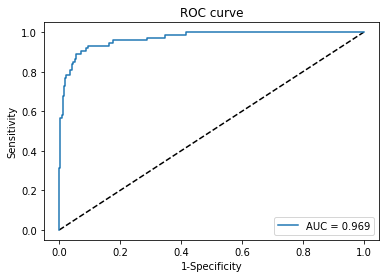

In [0]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_true, Y_score)
auc = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# Northwestern Data

In [0]:
model.eval()
model.to('cuda')
from sklearn.metrics import classification_report, confusion_matrix
#Confusion Matrix and Classification Report
Y_true = []
Y_pred = []
Y_score = []
tp2 = []
tp2_scores = []
fp2 = []
fp2_scores = []
tn2 = []
tn2_scores = []
fn2 = []
fn2_scores = []

with torch.no_grad():
    for i, data in enumerate(clinical_test_loader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = torch.softmax(model(inputs), dim = 1)
      _, predicted = torch.max(outputs, 1)
      score = outputs[:,1]
            
      for j in range(len(inputs)):
          Y_true.append(labels.cpu().numpy()[j])
          Y_pred.append(predicted.cpu().numpy()[j]) 
          Y_score.append(score.cpu().numpy()[j]) 
          if (Y_pred[BATCH_SIZE*i+j] == 1 and Y_true[BATCH_SIZE*i+j] == 1):
              tp2.append(inputs[j])
              tp2_scores.append(score[j])
          elif (Y_pred[BATCH_SIZE*i+j] == 1 and Y_true[BATCH_SIZE*i+j] == 0):
              fp2.append(inputs[j])
              fp2_scores.append(score[j])
          elif (Y_pred[BATCH_SIZE*i+j] == 0 and Y_true[BATCH_SIZE*i+j] == 0):
              tn2.append(inputs[j])
              tn2_scores.append(score[j])
          elif (Y_pred[BATCH_SIZE*i+j] == 0 and Y_true[BATCH_SIZE*i+j] == 1):
              fn2.append(inputs[j])
              fn2_scores.append(score[j])

print(confusion_matrix(Y_true, Y_pred))
target_names = ['COVID-Neg', 'COVID-Pos']
print(classification_report(Y_true, Y_pred, target_names=target_names))

[[ 7  0]
 [11  4]]
              precision    recall  f1-score   support

   COVID-Neg       0.39      1.00      0.56         7
   COVID-Pos       1.00      0.27      0.42        15

    accuracy                           0.50        22
   macro avg       0.69      0.63      0.49        22
weighted avg       0.81      0.50      0.47        22



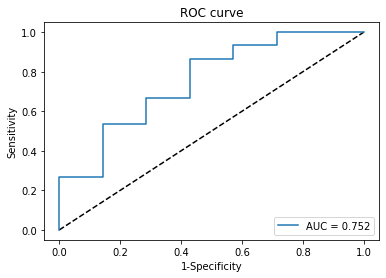

In [0]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_true, Y_score)
auc = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# Show TP, FP, TN, FN Images


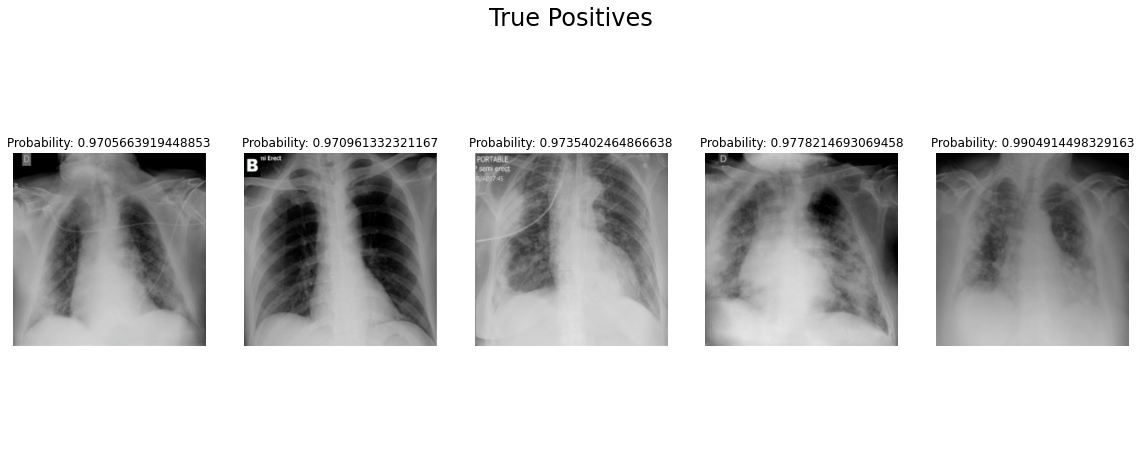

In [0]:
# get top 5 predictions
tp = [tp[i] for i in np.argpartition(tp_scores, -5)[-5:]]
tp_scores = [tp_scores[i] for i in np.argpartition(tp_scores, -5)[-5:]]

fig=plt.figure(figsize=(20, 8))
plt.title('True Positives', fontsize = 24)
plt.axis('off')
for i in range(1,len(tp)+1):
  image = tp[i-1].cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  ax = fig.add_subplot(1, len(tp), i)
  ax.axis('off')
  ax.title.set_text('Probability: {}'.format(tp_scores[i-1].item()))
  plt.imshow(image)
plt.show()

In [0]:
# get top predictions
fp = [fp[i] for i in np.argpartition(fp_scores, -4)[-4:]]
fp_scores = [fp_scores[i] for i in np.argpartition(fp_scores, -4)[-4:]]

fig=plt.figure(figsize=(20, 8))
plt.title('False Positives', fontsize = 24)
plt.axis('off')
for i in range(1,len(fp)+1):
  image = fp[i-1].cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  ax = fig.add_subplot(1, len(fp), i)
  ax.axis('off')
  ax.title.set_text('Probability: {}'.format(fp_scores[i-1].item()))
  plt.imshow(image)
plt.show()

ValueError: ignored

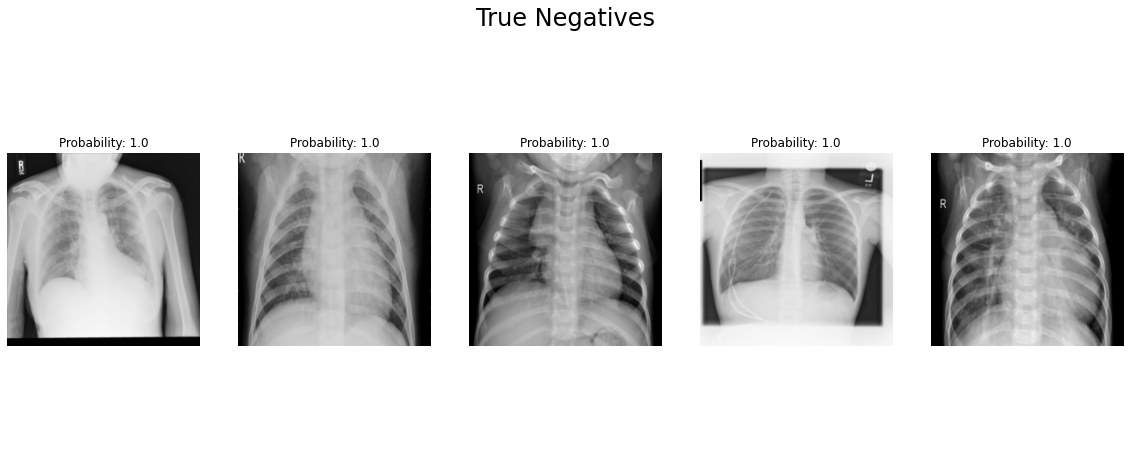

In [0]:
# get top 5 predictions
tn_scores = 1- np.array(tn_scores)
tn = [tn[i] for i in np.argpartition(tn_scores, -5)[-5:]]
tn_scores = [tn_scores[i] for i in np.argpartition(tn_scores, -5)[-5:]]

fig=plt.figure(figsize=(20, 8))
plt.title('True Negatives', fontsize = 24)
plt.axis('off')
for i in range(1,len(tn)+1):
  image = tn[i-1].cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  ax = fig.add_subplot(1, len(tn), i)
  ax.axis('off')
  ax.title.set_text('Probability: {}'.format(tn_scores[i-1].item()))
  plt.imshow(image)
plt.show()

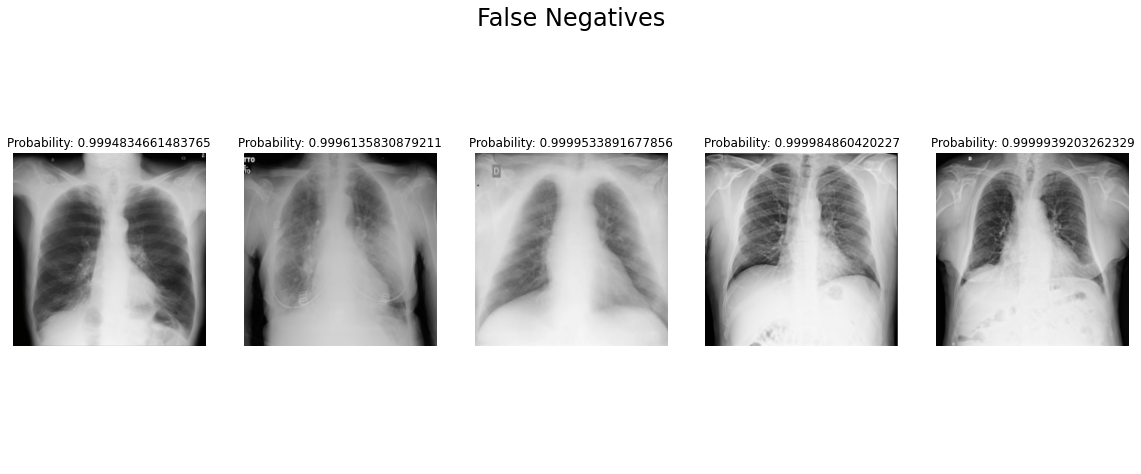

In [0]:
# get top 5 predictions
fn_scores = 1 - np.array(fn_scores)
fn = [fn[i] for i in np.argpartition(fn_scores, -5)[-5:]]
fn_scores = [fn_scores[i] for i in np.argpartition(fn_scores, -5)[-5:]]

fig=plt.figure(figsize=(20, 8))
plt.title('False Negatives', fontsize = 24)
plt.axis('off')
for i in range(1,len(fn)+1):
  image = fn[i-1].cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  ax = fig.add_subplot(1, len(fn), i)
  ax.axis('off')
  ax.title.set_text('Probability: {}'.format(fn_scores[i-1].item()))
  plt.imshow(image)
plt.show()

# Class Activation Mapping

In [0]:
# CAM function

def visualize_cam(img_path, model):

    from google.colab.patches import cv2_imshow
    from PIL import Image
  
    
    model.eval()
    model = model.to("cpu")

    
    img = Image.open(img_path)    
    img = transform(img)
    img=img.unsqueeze(0)
    # get the most likely prediction of the model
    pred = model(img)
    print('Positive Class Prediction Probability: ', torch.max(torch.softmax(pred, dim = 1)).item())

    # get the gradient of the output with respect to the parameters of the model
    pred[:, model(img).argmax(dim=1)[0]].backward()

    # pull the gradients out of the model
    gradients = model.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(img).detach()

    # weight the channels by corresponding gradients
    for j in range(2048):
        activations[:, j, :, :] *= pooled_gradients[j]
        
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    plt.matshow(heatmap.squeeze())

    # make the heatmap to be a numpy array
    heatmap = heatmap.numpy()

        
    # interpolate the heatmap
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
        

    imS = cv2.resize(superimposed_img, (256, 256))                    # Resize image
    img = cv2.resize(img, (256, 256))  
    cv2_imshow(img)
    cv2_imshow(imS)   


Positive Class Prediction Probability:  0.9416279196739197


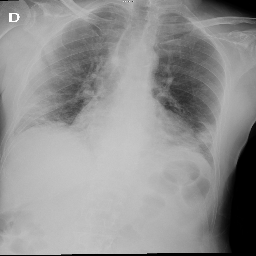

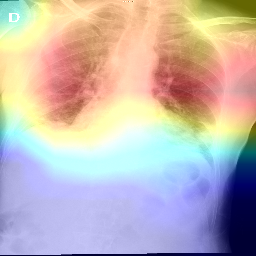

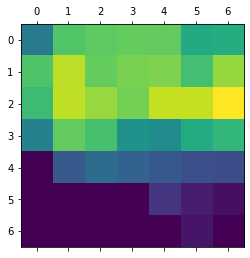

In [0]:
visualize_cam('/content/drive/My Drive/Colab Notebooks/data/CAM_Images/CAM_Image/Copy of Patient196(2).jpeg', model)

Positive Class Prediction Probability:  0.9136152863502502


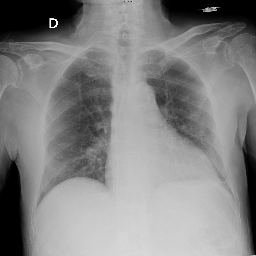

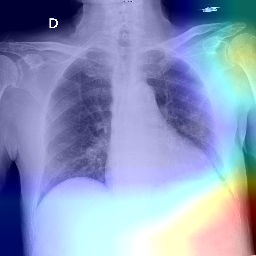

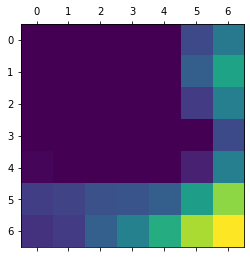

In [0]:
visualize_cam('/content/drive/My Drive/Colab Notebooks/data/CAM_Images/CAM_Image/Copy of Patient194.jpeg', model)

Positive Class Prediction Probability:  0.9343200922012329


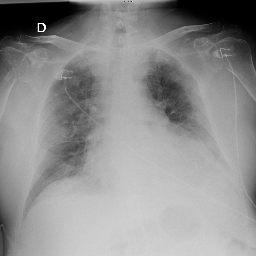

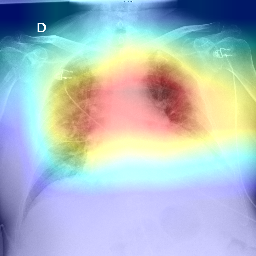

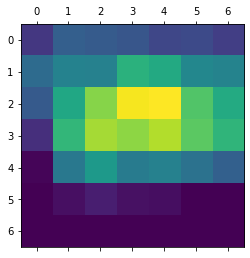

In [0]:
visualize_cam('/content/drive/My Drive/Colab Notebooks/data/CAM_Images/CAM_Image/Copy of Patient193(4).jpeg', model)

Positive Class Prediction Probability:  0.6009610295295715


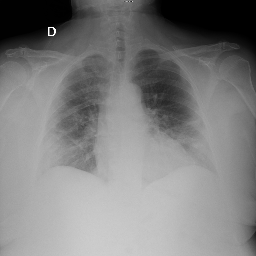

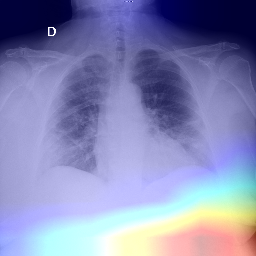

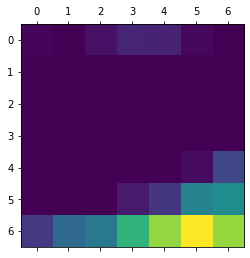

In [0]:
visualize_cam('/content/drive/My Drive/Colab Notebooks/data/CAM_Images/CAM_Image/Copy of Patient207.jpeg', model)

Positive Class Prediction Probability:  0.9885501265525818


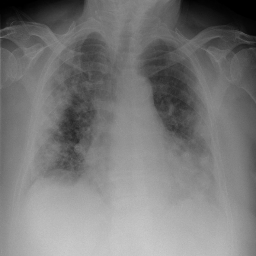

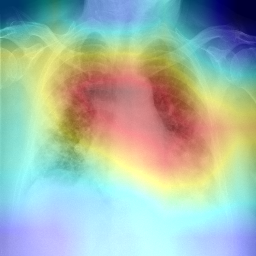

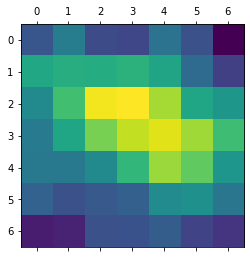

In [0]:
visualize_cam('/content/drive/My Drive/Colab Notebooks/data/CAM_Images/CAM_Image/Copy of Patient241.jpg', model)